### Imports

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from data import FloodEventDataset
from data.boundary_condition import BoundaryCondition
from data.dataset_normalizer import DatasetNormalizer
from matplotlib.patches import Patch
from typing import Callable, Tuple, List
from utils import file_utils, metric_utils, plot_utils

### Training Stats

In [2]:
training_stats_paths = [
    'results/dual_flood_gnn/DUALFloodGNN_train_metrics.npz',
]
train_labels = ['DUALFloodGNN']

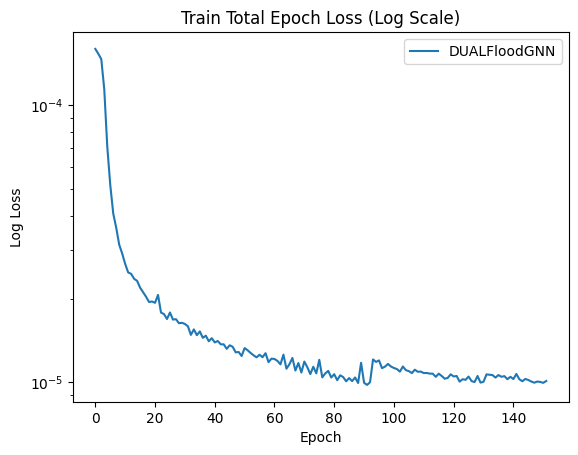

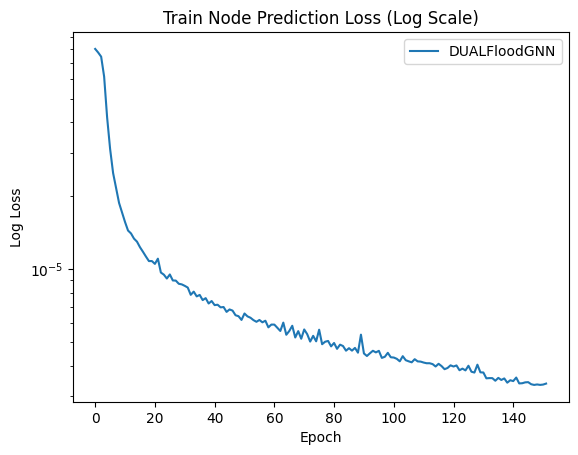

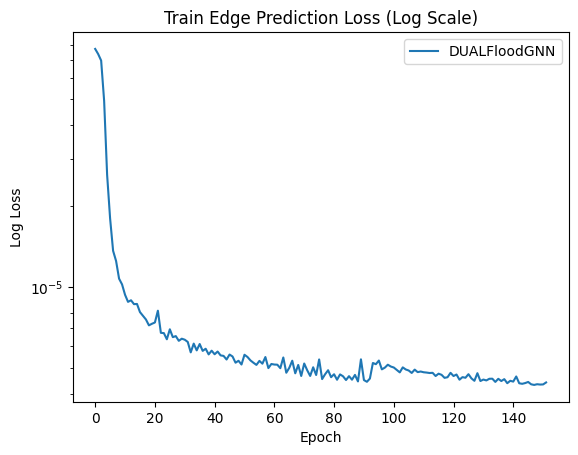

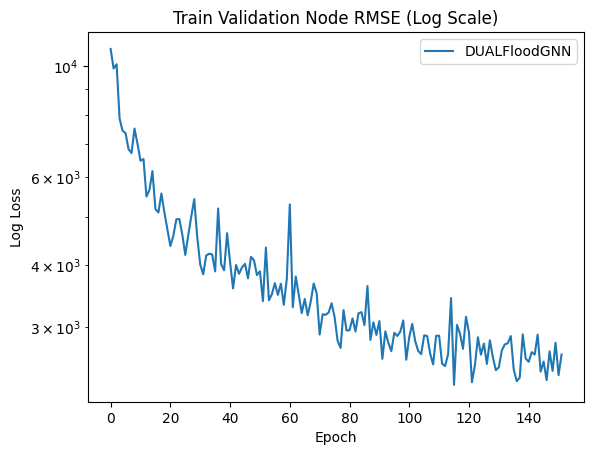

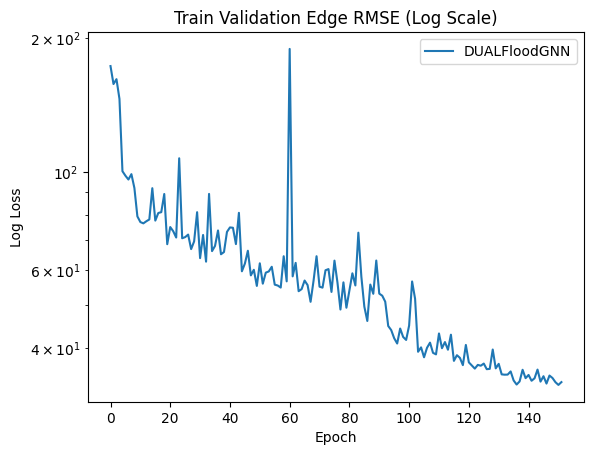

Metric 'orig_global_physics_loss' not found in any of the provided training stats paths.
Metric 'orig_local_physics_loss' not found in any of the provided training stats paths.


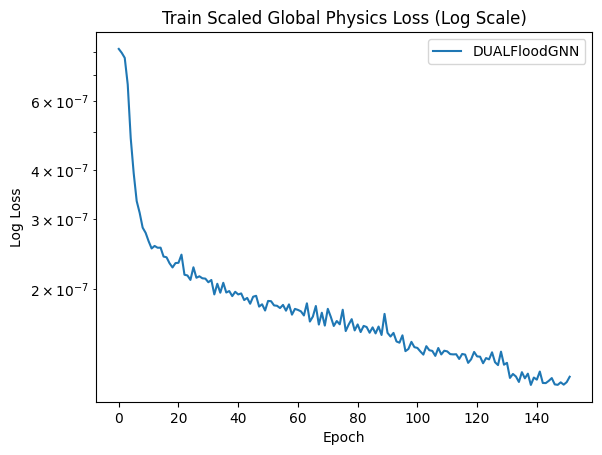

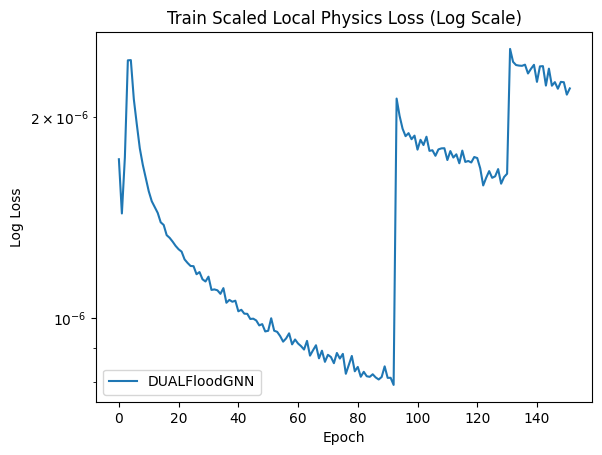

In [3]:
def get_default_label(path: str) -> str:
    return path.split('/')[-1].split('_')[0]

def plot_training_loss_for_all_models(stats_paths: list[str], metric: str, metric_name: str, start_epoch: int = 0, labels = None, log_scale: bool = False):
    is_metric_present = False
    for i, path in enumerate(stats_paths):
        label = labels[i] if labels is not None else get_default_label(path)
        train_stats = np.load(path, allow_pickle=True)
        if metric not in train_stats:
            continue

        is_metric_present = True
        train_loss = train_stats[metric][start_epoch:]
        color = f'C{i % 10}'
        plt.plot(train_loss, label=label, color=color)

    if not is_metric_present:
        print(f"Metric '{metric}' not found in any of the provided training stats paths.")
        return

    title = metric_name if metric_name is not None else metric.replace('_', ' ').title()

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'Train {title} (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'Train {title}')

    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

start_epoch = 0
log_scale = True

metrics = ['train_epoch_loss', 'prediction_loss', 'edge_prediction_loss', 'val_node_rmse', 'val_edge_rmse']
metric_names = ['Total Epoch Loss', 'Node Prediction Loss', 'Edge Prediction Loss', 'Validation Node RMSE', 'Validation Edge RMSE']

# Original Physics Loss
metrics += ['orig_global_physics_loss', 'orig_local_physics_loss']
metric_names += ['Global Physics Loss', 'Local Physics Loss']

# Scaled Physics Loss
metrics += ['global_physics_loss', 'local_physics_loss']
metric_names += ['Scaled Global Physics Loss', 'Scaled Local Physics Loss']

for metric, metric_name in zip(metrics, metric_names):
    plot_training_loss_for_all_models(training_stats_paths, metric, metric_name, start_epoch=start_epoch, labels=train_labels, log_scale=log_scale)

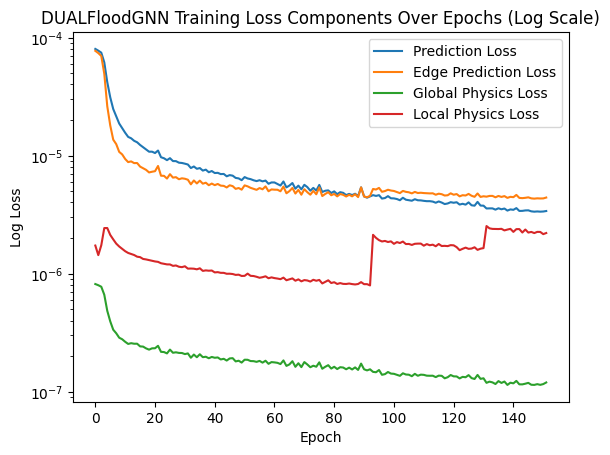

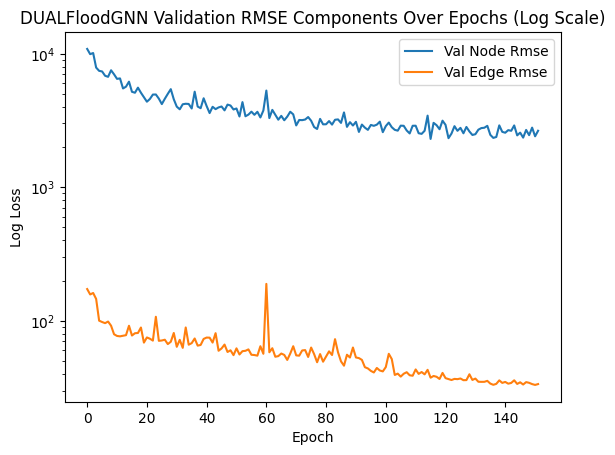

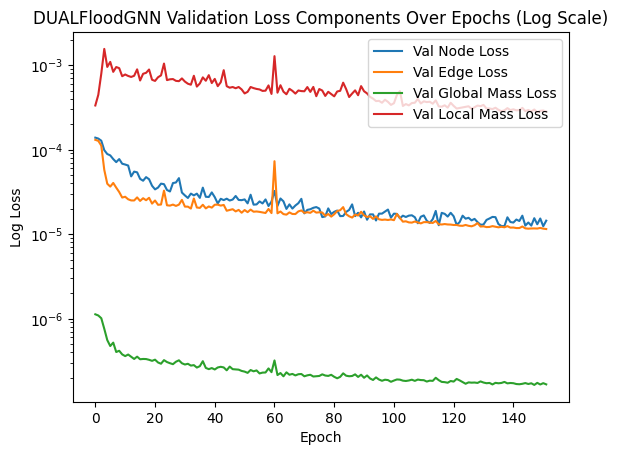

In [4]:
PATH_IDX = 0 # Change this index to select different training stats paths
train_stats_path = training_stats_paths[PATH_IDX]
label = train_labels[PATH_IDX] if train_labels is not None else None

# Training loss components
plot_utils.plot_loss_components(
    path=train_stats_path,
    loss_components=['prediction_loss', 'edge_prediction_loss', 'global_physics_loss', 'local_physics_loss'],
    title_prefix='Training Loss Components',
    start_epoch=start_epoch,
    model_label=label,
    log_scale=log_scale,
)

# Validation RMSE components
plot_utils.plot_loss_components(
    path=train_stats_path,
    loss_components=['val_node_rmse', 'val_edge_rmse'],
    title_prefix='Validation RMSE Components',
    start_epoch=start_epoch,
    model_label=label,
    log_scale=log_scale
)

# Validation loss components
plot_utils.plot_loss_components(
    path=train_stats_path,
    loss_components=['val_node_loss', 'val_edge_loss', 'val_global_mass_loss', 'val_local_mass_loss'],
    title_prefix='Validation Loss Components',
    start_epoch=start_epoch,
    model_label=label,
    log_scale=log_scale,
)

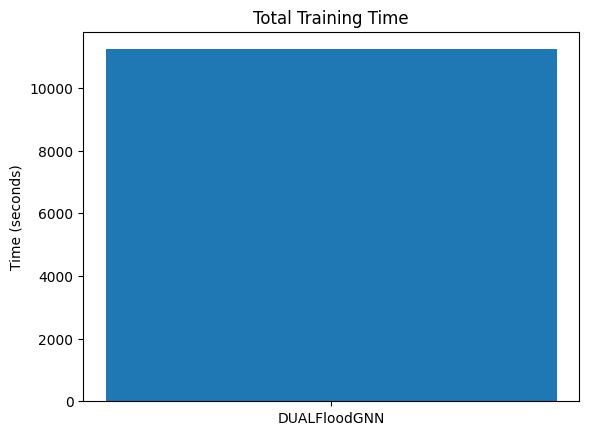

In [5]:
def plot_training_time_for_all_models(stats_paths: list[str], labels = None):
    if labels is None:
        labels = [get_default_label(path) for path in stats_paths]
    assert len(stats_paths) == len(labels), "Number of labels must match number of stats paths."

    all_train_time = []
    for path in stats_paths:
        train_time = np.load(path, allow_pickle=True)['train_time']
        all_train_time.append(train_time.item())

    plt.bar(labels, all_train_time)
    plt.title('Total Training Time')
    plt.ylabel('Time (seconds)')
    plt.show()

plot_training_time_for_all_models(training_stats_paths, labels=train_labels)

### Overall Metric Comparison

In [6]:
CONFIG_PATH = "configs/config.yaml"
CONSTANT_VALUES_PATH = "data/datasets/processed/constant_values.npz"
MESH_FACE_PATH = "data/datasets/raw/New_Geometry/faces.shp" # Set to None to disable mesh face display
INCLUDED_COMPONENTS =['edges'] # 'nodes' or 'edges'
# INCLUDED_COMPONENTS =['nodes'] # 'nodes' or 'edges'
RUN_ID = 39

# ========== Node Results ==========
# metric_paths = [
#     f'results/dual_flood_gnn/DUALFloodGNN_runid_{RUN_ID}_test_metrics.npz',
#     f'results/water_volume_baselines/HydroGraphNet_runid_{RUN_ID}_test_metrics.npz',
#     f'results/water_volume_baselines/GAT_runid_{RUN_ID}_test_metrics.npz',
#     f'results/water_volume_baselines/GCN_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['DUALFloodGNN', 'HydroGraphNet', 'GAT', 'GCN']

# ========== Edge Results ==========
metric_paths = [
    f'results/dual_flood_gnn/DUALFloodGNN_runid_{RUN_ID}_test_metrics.npz',
    f'results/water_flow_baselines/EdgeGAT_runid_{RUN_ID}_test_metrics.npz',
    f'results/water_flow_baselines/EdgeGCN_runid_{RUN_ID}_test_metrics.npz',
]
labels = ['DUALFloodGNN', 'GAT', 'GCN']

In [7]:
# Double check if constant values file exists
if not os.path.exists(CONSTANT_VALUES_PATH):
    raise FileNotFoundError(f"Constant values file not found at {CONSTANT_VALUES_PATH}. Process the FloodEventDataset first by either running train.py, test.py or eda.ipynb")

# Double check targets are the same
EPS = 1e-1
comparison_target = None
comparison_edge_target = None
for path in metric_paths:
    print('Checking target for', path)
    data = np.load(path, allow_pickle=True)
    if 'target' in data:
        target = data['target']
        if comparison_target is None:
            comparison_target = target
        else:
            assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'

    if 'edge_target' in data:
        edge_target = data['edge_target']
        if comparison_edge_target is None:
            comparison_edge_target = edge_target
        else:
            assert np.all((comparison_edge_target - edge_target) < EPS), f'Edge targets are not equal for {path}'

Checking target for results/dual_flood_gnn/DUALFloodGNN_runid_39_test_metrics.npz
Checking target for results/water_flow_baselines/EdgeGAT_runid_39_test_metrics.npz
Checking target for results/water_flow_baselines/EdgeGCN_runid_39_test_metrics.npz


In [8]:
x_ticks, x_ticks_labels, xlabel = plot_utils.get_x_ticks_from_timestamps(metric_paths)

def plot_metric_for_all_models(metric_paths: list[str], metric: str, metric_name: str = None, labels: list[str] = None, log_scale: bool = False):
    split_metric = metric.split('_') 
    if metric_name is None:
        metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))

    data_shape = None
    for i, path in enumerate(metric_paths):
        label = labels[i] if labels is not None else get_default_label(path)
        data = np.load(path, allow_pickle=True)
        if metric not in data or all(data[metric].shape) == 0:
            print(f"Metric '{metric}' is empty for path {path}. Skipping.")
            continue
        data = data[metric]

        print(f'Average {metric_name} for {label}: {np.mean(data):.4f}')
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        plt.plot(data, label=label, color=f'C{i % 10}')

    if log_scale:
        plt.yscale('log')
        plt.ylabel(f'{metric_name} (Log Scale)')
        plt.title(f'Test {metric_name} for Event {event_name} (Log Scale)')
    else:
        plt.title(f'Test {metric_name} for Event {event_name}')
        plt.ylabel(metric_name)

    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel(xlabel)
    plt.legend(framealpha=0)
    plt.show()

Average Edge RMSE for DUALFloodGNN: 32.5084
Average Edge RMSE for GAT: 178.6300
Average Edge RMSE for GCN: 96.0977


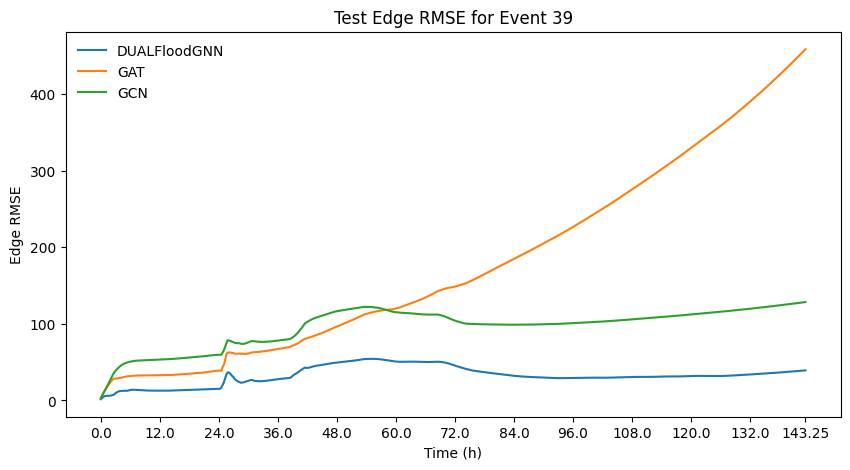

Average Edge MAE for DUALFloodGNN: 12.9901
Average Edge MAE for GAT: 48.2692
Average Edge MAE for GCN: 44.0146


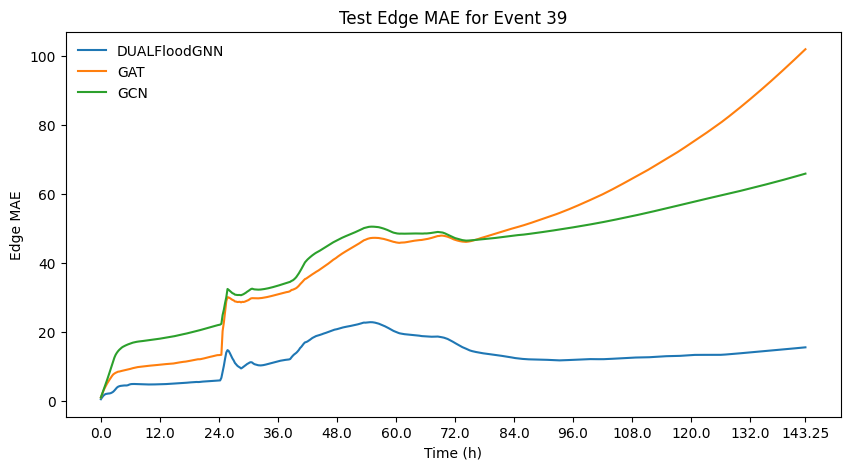

Average Edge NSE for DUALFloodGNN: 0.9746
Average Edge NSE for GAT: -1.1055
Average Edge NSE for GCN: 0.7236


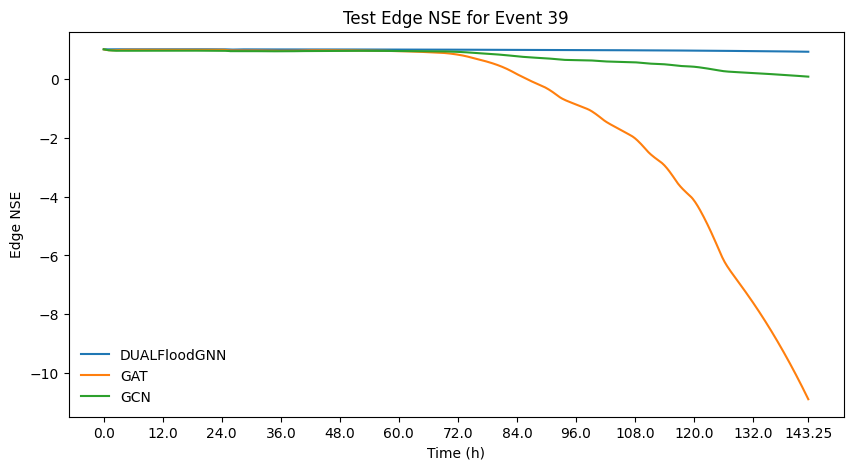

Average Global Mass Loss for DUALFloodGNN: 521.2470
Metric 'global_mass_loss' is empty for path results/water_flow_baselines/EdgeGAT_runid_39_test_metrics.npz. Skipping.
Metric 'global_mass_loss' is empty for path results/water_flow_baselines/EdgeGCN_runid_39_test_metrics.npz. Skipping.


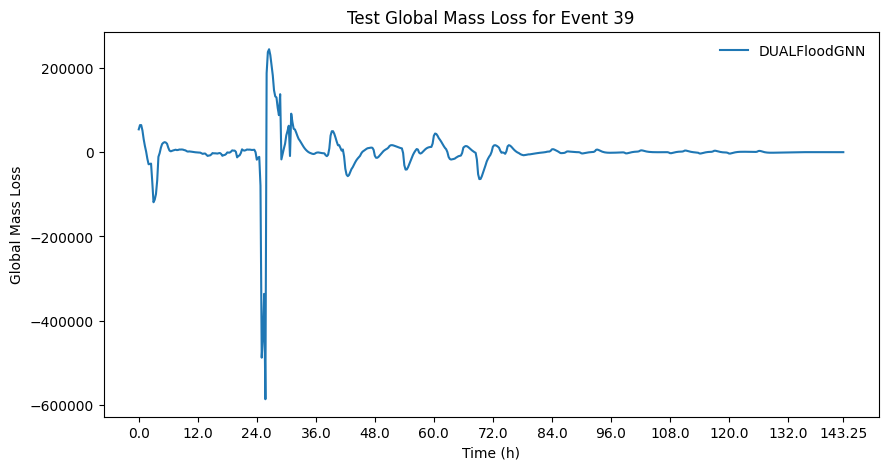

Average Local Mass Loss for DUALFloodGNN: 32694.1192
Metric 'local_mass_loss' is empty for path results/water_flow_baselines/EdgeGAT_runid_39_test_metrics.npz. Skipping.
Metric 'local_mass_loss' is empty for path results/water_flow_baselines/EdgeGCN_runid_39_test_metrics.npz. Skipping.


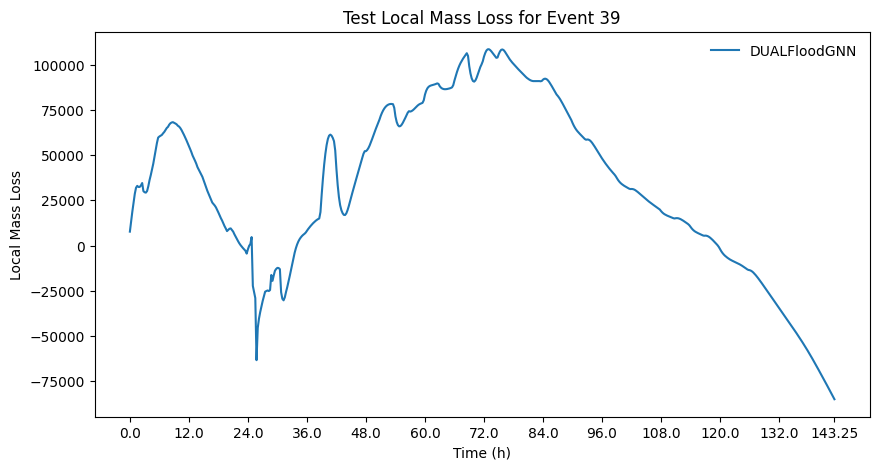

In [9]:
metrics = []
metric_names = []

if 'nodes' in INCLUDED_COMPONENTS:
    metrics += ['rmse', 'mae', 'nse', 'csi']
    metric_names += ['Node RMSE', 'Node MAE', 'Node NSE', 'Node CSI (Volume Threshold)']

    # Flooded Node Metrics
    # metrics += ['rmse_flooded', 'mae_flooded', 'nse_flooded']
    # metric_names += ['Node RMSE (flooded)', 'Node MAE (flooded)', 'Node NSE (flooded)']

if 'edges' in INCLUDED_COMPONENTS:
    metrics += ['edge_rmse', 'edge_mae', 'edge_nse']
    metric_names += ['Edge RMSE', 'Edge MAE', 'Edge NSE']

# Physics Metrics
metrics += ['global_mass_loss', 'local_mass_loss']
metric_names += ['Global Mass Loss', 'Local Mass Loss']

for metric, metric_name in zip(metrics, metric_names):
    plot_metric_for_all_models(metric_paths, metric, metric_name=metric_name, labels=labels, log_scale=False)

In [10]:
def plot_total_water_volume_for_all_models(metric_paths: list[str], ground_truth: np.ndarray = None, labels: list[str] = None, end_timestep: int = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.title(f'Total Water Volume Over Time for Event {event_name}')

    if ground_truth is not None:
        gt_total_volume = ground_truth.sum(axis=1)
        if end_timestep is not None:
            gt_total_volume = gt_total_volume[:end_timestep]
        plt.plot(gt_total_volume, label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        data = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for path {path}: {data.shape} vs {data_shape}"

        label = labels[i] if labels is not None else get_default_label(path)
        pred_total_volume = data.sum(axis=1)
        if end_timestep is not None:
            pred_total_volume = pred_total_volume[:end_timestep]
        plt.plot(pred_total_volume, label=label)

    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel(xlabel)
    plt.ylabel('Water Volume (m³)')
    plt.legend(framealpha=0)
    plt.show()

if 'nodes' in INCLUDED_COMPONENTS:
    vol_ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
    plot_total_water_volume_for_all_models(metric_paths, ground_truth=vol_ground_truth, labels=labels)

### Node Analysis

In [11]:
BOUNDARY_NODE_IDX = [718, 434, 858] # Nodes connected to boundary conditions
SELECTED_NODE_IDX = [534, 644, 767, 463] # Nodes along the river
node_idxs = SELECTED_NODE_IDX # + BOUNDARY_NODE_IDX

if 'nodes' in INCLUDED_COMPONENTS:
    for node_idx in node_idxs:
        peak_wv = vol_ground_truth[:, node_idx].max()
        peak_wv_timestep = vol_ground_truth[:, node_idx].argmax()
        print(f"(Run ID {RUN_ID}) Peak water volume for node {node_idx}: {peak_wv} (timestep {peak_wv_timestep})")

In [12]:
def hide_remaining_axes(axes, start_index: int, nrows: int, ncols: int):
    total_axes = nrows * ncols
    for i in range(start_index, total_axes):
        ax = get_axis_from_subplot(axes, nrows, ncols, i)
        ax.set_visible(False)
        ax.set_axis_off()

def get_axis_from_subplot(axes, nrows: int, ncols: int, index: int) -> plt.Axes:
    if nrows == 1:
        return axes[index]
    else:
        ax_row = index // ncols
        ax_col = index % ncols
        return axes[ax_row, ax_col]

def plot_timeseries_over_indices(metric_paths: List[str],
                                 indices: List[int],
                                 ground_truth: np.ndarray = None,
                                 pred_key: str = 'pred',
                                 ylabel: str = 'Value',
                                 index_label: str = 'Index',
                                 suptitle: str = 'Timeseries Plot',
                                 n_cols: int = 2,
                                 labels: List[str] = None):
    metrics = [np.load(path, allow_pickle=True) for path in metric_paths]
    if labels is None:
        labels = [get_default_label(path) for path in metric_paths]

    num_indices = len(indices)
    ncols = min(n_cols, num_indices)
    nrows = (num_indices + ncols - 1) // ncols

    _, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows))
    if num_indices == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes if ncols > 1 else [axes]
    else:
        axes = axes.flatten()

    for idx_pos, idx in enumerate(indices):
        ax = axes[idx_pos]
        handles = []

        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)

        if ground_truth is not None:
           gt_line, = ax.plot(ground_truth[:, idx], label='Ground Truth', color='black')
           handles.append(gt_line)

        data_shape = None
        for i, data in enumerate(metrics):
            pred = data[pred_key]

            if data_shape is None:
                data_shape = pred.shape
            assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

            line, = ax.plot(pred[:, idx], label=labels[i])
            handles.append(line)

        ax.set_title(f'{index_label} {idx}', fontsize=14)
        ax.legend(handles=handles, labels=['Ground Truth', *labels] if ground_truth is not None else labels, framealpha=0)

    hide_remaining_axes(axes, num_indices, nrows, ncols)
    
    plt.suptitle(suptitle, fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.tight_layout()


if 'nodes' in INCLUDED_COMPONENTS:
    plot_timeseries_over_indices(
        metric_paths=metric_paths,
        indices=node_idxs,
        ground_truth=vol_ground_truth,
        pred_key='pred',
        ylabel='Water Volume (m³)',
        index_label='Node',
        suptitle='Water Volume Over Time for Selected Nodes',
        n_cols=2,
        labels=labels,
    )

In [13]:
if 'nodes' in INCLUDED_COMPONENTS:
    for node in node_idxs:
        print(f'Calculating NSE for node {node}...')
        node_gt = torch.Tensor(vol_ground_truth[:, node])
        for i, path in enumerate(metric_paths):
            pred = np.load(path, allow_pickle=True)['pred']
            node_pred = torch.Tensor(pred[:, node])
            nse = metric_utils.NSE(node_pred, node_gt)
            label =  labels[i] if labels is not None else get_default_label(path)
            print(f'\tNSE for {label}: {nse:.4f}')

In [14]:
BOUNDARY_EDGE_IDX = [2470, 2471, 2472] # Edges connected to boundary nodes
SELECTED_EDGE_IDX = [1609, 1101, 1897, 559] # Edges along the river
edge_idxs = SELECTED_EDGE_IDX # + BOUNDARY_EDGE_IDX

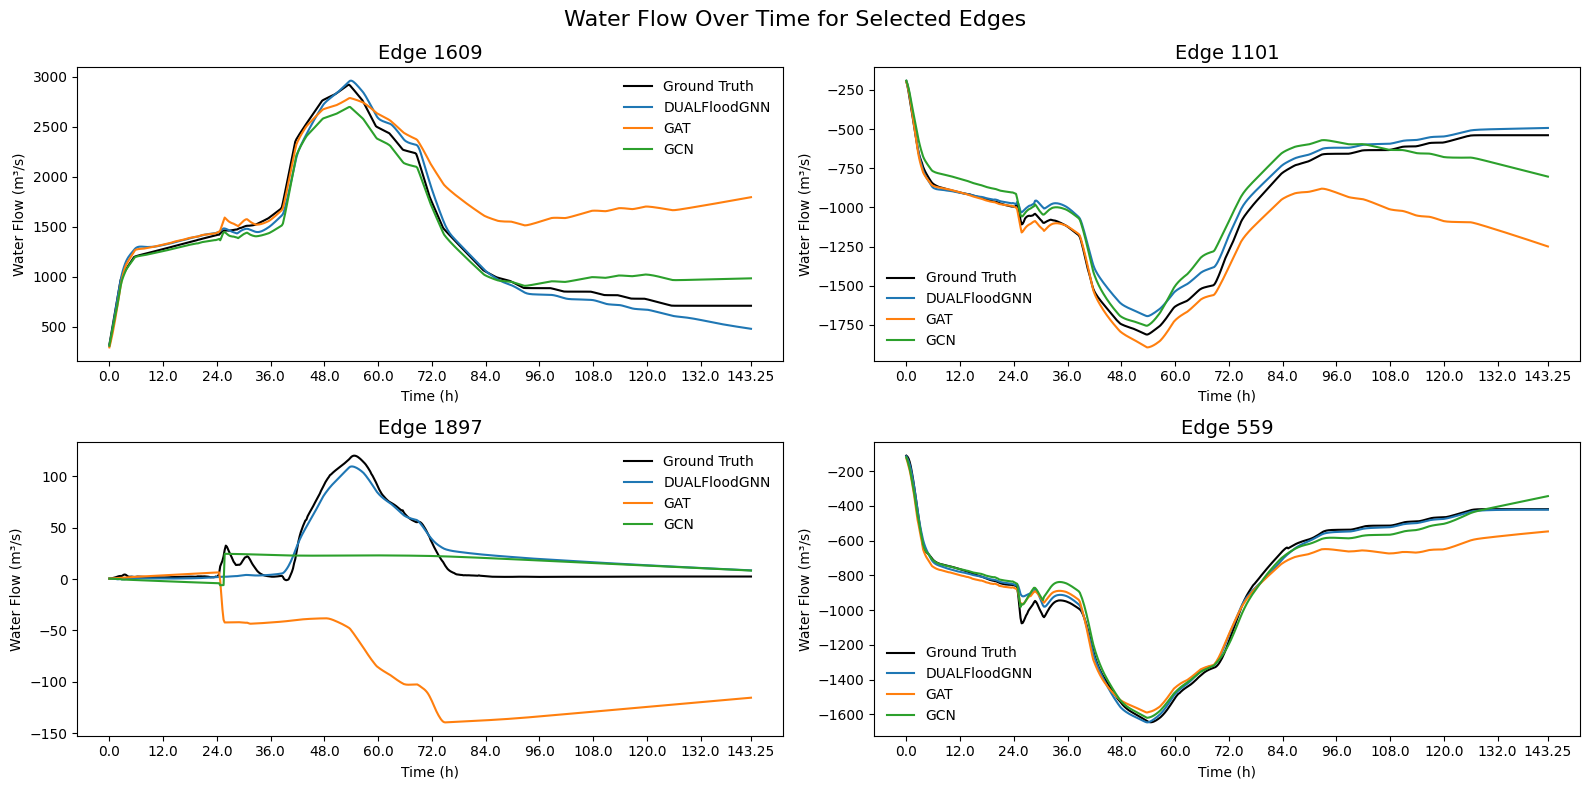

In [15]:
if 'edges' in INCLUDED_COMPONENTS:
    flow_ground_truth = np.load(metric_paths[0], allow_pickle=True)['edge_target']
    plot_timeseries_over_indices(
        metric_paths=metric_paths,
        indices=edge_idxs,
        ground_truth=flow_ground_truth,
        pred_key='edge_pred',
        ylabel='Water Flow (m³/s)',
        index_label='Edge',
        suptitle='Water Flow Over Time for Selected Edges',
        n_cols=2,
        labels=labels,
    )

In [16]:
if 'edges' in INCLUDED_COMPONENTS:
    for edge in edge_idxs:
        print(f'Calculating NSE for edge {edge}...')
        edge_gt = torch.Tensor(flow_ground_truth[:, edge])
        for i, path in enumerate(metric_paths):
            pred = np.load(path, allow_pickle=True)['edge_pred']
            edge_pred = torch.Tensor(pred[:, edge])
            nse = metric_utils.NSE(edge_pred, edge_gt)
            label =  labels[i] if labels is not None else get_default_label(path)
            print(f'\tNSE for {label}: {nse:.4f}')

Calculating NSE for edge 1609...
	NSE for DUALFloodGNN: 0.9808
	NSE for GAT: 0.2932
	NSE for GCN: 0.9499
Calculating NSE for edge 1101...
	NSE for DUALFloodGNN: 0.9685
	NSE for GAT: 0.4554
	NSE for GCN: 0.9128
Calculating NSE for edge 1897...
	NSE for DUALFloodGNN: 0.8805
	NSE for GAT: -11.1838
	NSE for GCN: 0.1509
Calculating NSE for edge 559...
	NSE for DUALFloodGNN: 0.9953
	NSE for GAT: 0.9340
	NSE for GCN: 0.9868


### Flood Map Analysis

In [17]:
def get_max_flood_map(metric_path: str, property: str) -> np.ndarray:
    per_cell_volume = np.load(metric_path, allow_pickle=True)[property]
    max_flood_map = per_cell_volume.max(axis=0)
    return max_flood_map

def plot_cell_map(axis, gpdf: gpd.GeoDataFrame, value: np.ndarray, title: str, cmap = None, vmin: float = None, vmax: float = None):
    value_column = 'is_flooded'
    if cmap is None:
        cmap = plot_utils.get_trimmed_cmap('Blues', start=0.3, end=1.0)

    shared_plot_kwargs = {
        'cmap': cmap,
        'column': value_column,
        # 'linewidth': 0.3,
        # 'markersize': 3,
        # 'linewidth': 0.5,
        # 'edgecolor': 'black',
        # 'alpha': 0.9,
    }

    # Add vmin/vmax if provided for consistent color scaling
    if vmin is not None and vmax is not None:
        shared_plot_kwargs['vmin'] = vmin
        shared_plot_kwargs['vmax'] = vmax

    gpdf[value_column] = value
    plot_obj = gpdf.plot(ax=axis, **shared_plot_kwargs)
    axis.set_title(title)
    axis.set_axis_off()

    return plot_obj

In [18]:
if 'nodes' in INCLUDED_COMPONENTS:
    max_flood_map_gt = get_max_flood_map(metric_paths[0], 'target')

    print(f'Calculating RMSE for max flood maps...')
    for i, path in enumerate(metric_paths):
        pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
        rmse = metric_utils.RMSE(pred_max_flood_map, torch.Tensor(max_flood_map_gt))
        label =  labels[i] if labels is not None else get_default_label(path)
        print(f'\tRMSE for {label}: {rmse:.4f}')

    print(f'Calculating MAE for max flood maps...')
    for i, path in enumerate(metric_paths):
        pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
        mae = metric_utils.MAE(pred_max_flood_map, torch.Tensor(max_flood_map_gt))
        label =  labels[i] if labels is not None else get_default_label(path)
        print(f'\tMAE for {label}: {mae:.4f}')

In [19]:
config = file_utils.read_yaml_file(CONFIG_PATH)

node_df = plot_utils.get_node_df(config, RUN_ID, mode='test', no_ghost=True)
if MESH_FACE_PATH is not None:
    cells_df = gpd.read_file(MESH_FACE_PATH).polygonize()
    node_df = plot_utils.map_centers_to_polygons(cells_df, node_df)

In [20]:
def plot_max_map_difference(metric_paths: list[str],
                            gpdf: gpd.GeoDataFrame,
                            ground_truth: np.ndarray,
                            max_map_func: Callable,
                            pred_key: str = 'pred',
                            colorbar_label: str = 'Value',
                            map_type: str = 'Flood',
                            labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    n_cols = 3
    n_rows = len(metric_paths)
    
    fig, axes = plt.subplots(figsize=(13, 4 * n_rows), nrows=n_rows, ncols=n_cols)
    fig.suptitle(f'Max Flood {map_type} Maps for Event {event_name}')

    vmin = ground_truth.min()
    vmax = ground_truth.max()

    for i, metric_path in enumerate(metric_paths):
        label = labels[i] if labels is not None else get_default_label(metric_path)

        # Column 0: Ground Truth
        plot_obj = plot_cell_map(axes[i, 0], gpdf, ground_truth, title='Ground Truth',
                                 vmin=vmin, vmax=vmax)

        # Column 1: Prediction
        pred = max_map_func(metric_path, pred_key)
        plot_cell_map(axes[i, 1], gpdf, pred, title=f'{label} \n Prediction', 
                     vmin=vmin, vmax=vmax)
        
        # Column 2: Absolute Difference
        diff_map = np.abs(ground_truth - pred)
        plot_cell_map(axes[i, 2], gpdf, diff_map, title=f'{label} \n Absolute Difference', 
                     vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(plot_obj.collections[0], cax=cbar_ax)
    cbar.set_label(colorbar_label, rotation=270, labelpad=15)
    plt.subplots_adjust(right=0.9, hspace=0.3, wspace=-0.2, top=0.93)

    plt.show()

In [21]:
if 'nodes' in INCLUDED_COMPONENTS:
    plot_max_map_difference(
        metric_paths=metric_paths,
        gpdf=node_df,
        ground_truth=max_flood_map_gt,
        max_map_func=get_max_flood_map,
        pred_key='pred',
        colorbar_label='Water Volume (m³)',
        map_type='Volume',
        labels=labels
    )

In [22]:
def plot_vol_map_at_timestep_for_all_models(metric_paths: list[str],
                                            node_df: gpd.GeoDataFrame,
                                            timestep: int,
                                            labels: list[str] = None):
    ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
    vmin, vmax = ground_truth.min(), ground_truth.max()
    ts_gt_flood_map = ground_truth[timestep]

    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3  # Ground truth, prediction, difference
    nrows = len(metric_paths)  # One row per model
    
    if labels is None:
        labels = [get_default_label(path) for path in metric_paths]

    # Get flood maps for all paths at the specified timestep
    flood_maps = []
    data_shape = None
    for path in metric_paths:
        pred = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        ts_flood_map = pred[timestep]
        flood_maps.append(ts_flood_map)

    # Calculate difference maps
    diff_maps = []
    for map_data in flood_maps:
        diff_map = np.abs(map_data - ts_gt_flood_map)
        diff_maps.append(diff_map)

    fig, ax = plt.subplots(figsize=(13, 4*nrows), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Flood Volume Maps at Timestep {timestep} for Event {event_name}')

    for i, (map_data, diff_map, label) in enumerate(zip(flood_maps, diff_maps, labels)):
        row = i

        # Ground truth
        axis = get_axis_from_subplot(ax, nrows, ncols, row * ncols)
        plot_obj_gt = plot_cell_map(axis, node_df, ts_gt_flood_map, 
                                   title=f'Ground Truth', vmin=vmin, vmax=vmax)
        
        # Prediction
        axis = get_axis_from_subplot(ax, nrows, ncols, row * ncols + 1)
        plot_obj_pred = plot_cell_map(axis, node_df, map_data, 
                                     title=f'{label} Prediction', vmin=vmin, vmax=vmax)
        
        # Difference (Prediction - Ground Truth)
        axis = get_axis_from_subplot(ax, nrows, ncols, row * ncols + 2)
        plot_obj_diff = plot_cell_map(axis, node_df, diff_map, 
                                     title=f'Absolute Difference', vmin=vmin, vmax=vmax)

    # Add colorbars
    if plot_obj_gt is not None:
        # # Colorbar for ground truth and predictions
        # cbar_ax1 = fig.add_axes([0.68, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        # cbar1 = fig.colorbar(plot_obj_pred.collections[0], cax=cbar_ax1)
        # cbar1.set_label('Water Volume (m³)', rotation=270, labelpad=15)

        # Colorbar for differences
        cbar_ax2 = fig.add_axes([0.72, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar2 = fig.colorbar(plot_obj_diff.collections[0], cax=cbar_ax2)
        cbar2.set_label('Volume Difference (m³)', rotation=270, labelpad=15)
    
    plt.subplots_adjust(right=0.7, hspace=0.3, wspace=0)
    plt.show()

In [23]:
TIMESTEP = 0  # Change this to the desired timestep
if 'nodes' in INCLUDED_COMPONENTS:
    plot_vol_map_at_timestep_for_all_models(metric_paths,
                                            node_df,
                                            timestep=TIMESTEP,
                                            labels=labels)

In [24]:
def get_max_flow_map(metric_path: str, property: str) -> np.ndarray:
    data = np.load(metric_path, allow_pickle=True)
    if property not in data or data[property] is None or len(data[property]) == 0:
        return None
    
    per_edge_flow = data[property]
    per_edge_flow = np.abs(per_edge_flow) # Use absolute value as we don't care about direction
    max_flow_map = per_edge_flow.max(axis=0)
    return max_flow_map

In [25]:
if 'edges' in INCLUDED_COMPONENTS:
    max_flow_map_gt = get_max_flow_map(metric_paths[0], 'edge_target')

    print(f'Calculating RMSE for max flow maps...')
    for i, path in enumerate(metric_paths):
        data = np.load(path, allow_pickle=True)
        if 'edge_pred' not in data or data['edge_pred'] is None or len(data['edge_pred']) == 0:
            print(f"Skipping RMSE calculation for {path} as 'edge_pred' not found in the data.")
            continue

        pred_max_flow_map = torch.Tensor(get_max_flow_map(path, 'edge_pred'))
        rmse = metric_utils.RMSE(pred_max_flow_map, torch.Tensor(max_flow_map_gt))
        label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        print(f'\tRMSE for {label}: {rmse:.4f}')

Calculating RMSE for max flow maps...
	RMSE for DUALFloodGNN: 56.0996
	RMSE for GAT: 328.8624
	RMSE for GCN: 125.3554


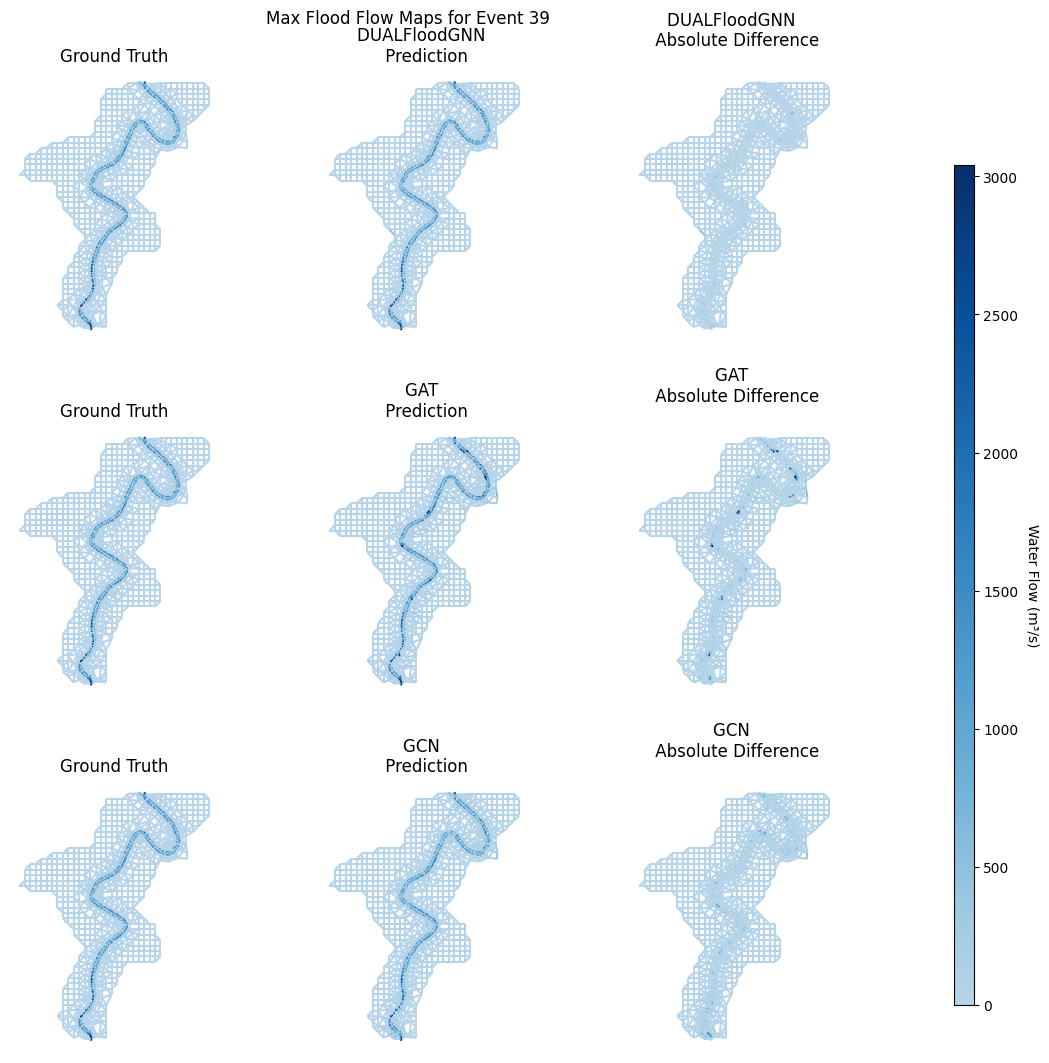

In [26]:
if 'edges' in INCLUDED_COMPONENTS:
    edge_df = plot_utils.get_edge_df(config, RUN_ID, mode='test', no_ghost=True)
    plot_max_map_difference(
        metric_paths=metric_paths,
        gpdf=edge_df,
        ground_truth=max_flow_map_gt,
        max_map_func=get_max_flow_map,
        pred_key='edge_pred',
        colorbar_label='Water Flow (m³/s)',
        map_type='Flow',
        labels=labels
    )

### Water Depth Analysis

In [27]:
vol_metric_paths = [
    f'results/dual_flood_gnn/DUALFloodGNN_runid_{RUN_ID}_test_metrics.npz',
]
vol_metric_labels = ['DUALFloodGNN']

wd_metric_paths = [
    f'results/water_depth_baselines/HydroGraphNet_runid_{RUN_ID}_test_metrics.npz',
    f'results/water_depth_baselines/SWEGNN_run_id_{RUN_ID}_metrics.npz',
]
wd_metric_labels = ['HydroGraphNet', 'SWE-GNN']

wd_paths = [*vol_metric_paths, *wd_metric_paths]
wd_labels = [*vol_metric_labels, *wd_metric_labels]

In [28]:
# Double check targets are the same
EPS = 1e-1
comparison_target = None
for path in wd_metric_paths:
    print('Checking target for', path)
    data = np.load(path, allow_pickle=True)
    target = data['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'

wd_ground_truth = np.load(wd_metric_paths[0], allow_pickle=True)['target']

Checking target for results/water_depth_baselines/HydroGraphNet_runid_39_test_metrics.npz
Checking target for results/water_depth_baselines/SWEGNN_run_id_39_metrics.npz


In [29]:
def get_hecras_file_path_from_config(config: dict, run_id: str) -> str:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']

    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
    summary_df = pd.read_csv(dataset_summary_path)
    summary_df = summary_df[summary_df['Run_ID'] == run_id]

    hec_ras_file = summary_df['HECRAS_Filepath'].values[0]
    hec_ras_file_path = os.path.join(root_dir, 'raw', hec_ras_file)
    return hec_ras_file_path

def get_boundary_condition(config: dict, run_id: str) -> BoundaryCondition:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']

    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
    summary_df = pd.read_csv(dataset_summary_path)
    summary_df = summary_df[summary_df['Run_ID'] == run_id]
    hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

    inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
    outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

    bc = BoundaryCondition(root_dir=root_dir,
                           hec_ras_file=hec_ras_file,
                           inflow_boundary_nodes=inflow_boundary_nodes,
                           outflow_boundary_nodes=outflow_boundary_nodes,
                           saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
    return bc

def get_node_elevation(constant_values_path: str, run_id: int) -> np.ndarray:
    dataset_parameters = config['dataset_parameters']

    # Get elevation
    constant_values = np.load(constant_values_path)
    static_nodes = constant_values['static_nodes']
    static_nodes = np.load(constant_values_path)['static_nodes']
    elevation_idx = FloodEventDataset.STATIC_NODE_FEATURES.index('elevation')
    elevation = static_nodes[:, elevation_idx]

    # Denormalize
    root_dir = dataset_parameters['root_dir']
    if dataset_parameters['normalize']:
        features_stats_file = dataset_parameters['features_stats_file']
        normalizer = DatasetNormalizer(mode='test', root_dir=root_dir, features_stats_file=features_stats_file)
        elevation = normalizer.denormalize('elevation', elevation)

    # Filter out boundary nodes
    bc = get_boundary_condition(config, run_id)
    non_boundary_nodes_mask = ~bc.boundary_nodes_mask
    elevation = elevation[non_boundary_nodes_mask, None]

    return elevation

In [30]:
config = file_utils.read_yaml_file(CONFIG_PATH)
hec_ras_file_path = get_hecras_file_path_from_config(config, RUN_ID)
print(f'Using HEC-RAS file: {hec_ras_file_path} for run ID {RUN_ID}')

elevation = get_node_elevation(CONSTANT_VALUES_PATH, RUN_ID)

Using HEC-RAS file: data/datasets\raw\HEC-RAS Results/Model_01.p44.hdf for run ID 39


In [31]:
i = 0
wd_predictions = []

for path in vol_metric_paths:
    assert path == wd_paths[i]

    vol_pred = np.load(path, allow_pickle=True)['pred']
    print(f'Interpolating water level from volume for path number {i+1}...')
    wl_pred = metric_utils.interpolate_wl_from_vol(vol_pred, hec_ras_file_path)

    repeat_elevation = np.repeat(elevation[None, :, :], wl_pred.shape[0], axis=0)
    wd_pred = wl_pred - repeat_elevation
    wd_pred = np.clip(wd_pred, a_min=0, a_max=None)
    wd_predictions.append(wd_pred)

    i += 1

for path in wd_metric_paths:
    assert path == wd_paths[i]

    wd_pred = np.load(path, allow_pickle=True)['pred']
    wd_predictions.append(wd_pred)

    i += 1

assert len(wd_predictions) == len(wd_paths)

Interpolating water level from volume for path number 1...
Completed interpolation for timestep 0/574
Completed interpolation for timestep 100/574
Completed interpolation for timestep 200/574
Completed interpolation for timestep 300/574
Completed interpolation for timestep 400/574
Completed interpolation for timestep 500/574


In [32]:
print(f'Calculating overall water depth metrics for event {RUN_ID}...')
print('RMSE:')
for wd_pred, label in zip(wd_predictions, wd_labels):
    rmse = metric_utils.RMSE(torch.Tensor(wd_pred), torch.Tensor(wd_ground_truth))
    print(f'\t{label}: {rmse:.4f}')

print('MAE:')
for wd_pred, label in zip(wd_predictions, wd_labels):
    mae = metric_utils.MAE(torch.Tensor(wd_pred), torch.Tensor(wd_ground_truth))
    print(f'\t{label}: {mae:.4f}')

print('NSE:')
for wd_pred, label in zip(wd_predictions, wd_labels):
    nse = metric_utils.NSE(torch.Tensor(wd_pred), torch.Tensor(wd_ground_truth))
    print(f'\t{label}: {nse:.4f}')

thresholds = [0.05, 0.3]
for threshold in thresholds:
    print(f'CSI (threshold = {threshold} m):')
    for wd_pred, label in zip(wd_predictions, wd_labels):
        binary_wd_pred = torch.Tensor(wd_pred) > threshold
        binary_wd_gt = torch.Tensor(wd_ground_truth) > threshold
        csi = metric_utils.CSI(binary_wd_pred, binary_wd_gt)
        print(f'\t{label}: {csi:.4f}')

Calculating overall water depth metrics for event 39...
RMSE:
	DUALFloodGNN: 0.2761
	HydroGraphNet: 0.5517
	SWE-GNN: 1.6472
MAE:
	DUALFloodGNN: 0.0835
	HydroGraphNet: 0.2107
	SWE-GNN: 0.9042
NSE:
	DUALFloodGNN: 0.9799
	HydroGraphNet: 0.9198
	SWE-GNN: 0.2851
CSI (threshold = 0.05 m):
	DUALFloodGNN: 0.8952
	HydroGraphNet: 0.5882
	SWE-GNN: 0.2635
CSI (threshold = 0.3 m):
	DUALFloodGNN: 0.9039
	HydroGraphNet: 0.8058
	SWE-GNN: 0.2373


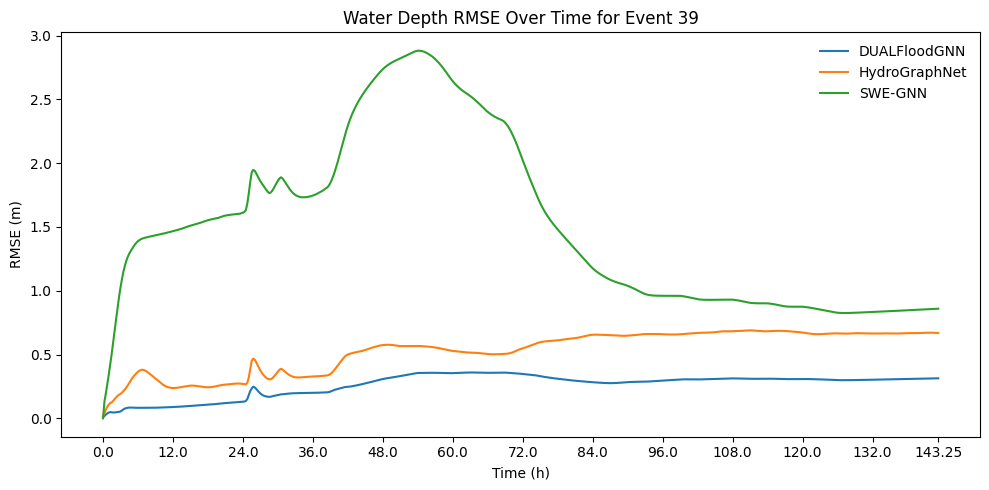

In [33]:
def plot_wd_rmse_over_time(wd_predictions: list[np.ndarray],
                           metric_paths: list[str],
                           ground_truth: np.ndarray,
                           labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    if labels is None:
        labels = [get_default_label(path) for path in metric_paths]

    plt.figure(figsize=(10, 5))
    
    # Calculate RMSE for each timestep for each prediction
    for i, wd_pred in enumerate(wd_predictions):
        rmse_per_timestep = []
        for t in range(wd_pred.shape[0]):
            rmse_t = metric_utils.RMSE(torch.Tensor(wd_pred[t]), torch.Tensor(ground_truth[t]))
            rmse_per_timestep.append(rmse_t.item())
        
        plt.plot(rmse_per_timestep, label=labels[i], color=f'C{i % 10}')
    
    plt.title(f'Water Depth RMSE Over Time for Event {event_name}')
    plt.ylabel('RMSE (m)')
    plt.xticks(ticks=x_ticks, labels=x_ticks_labels)
    plt.xlabel(xlabel)

    plt.legend(framealpha=0)
    plt.tight_layout()
    plt.show()

plot_wd_rmse_over_time(wd_predictions,
                       wd_paths,
                       wd_ground_truth,
                       labels=wd_labels)

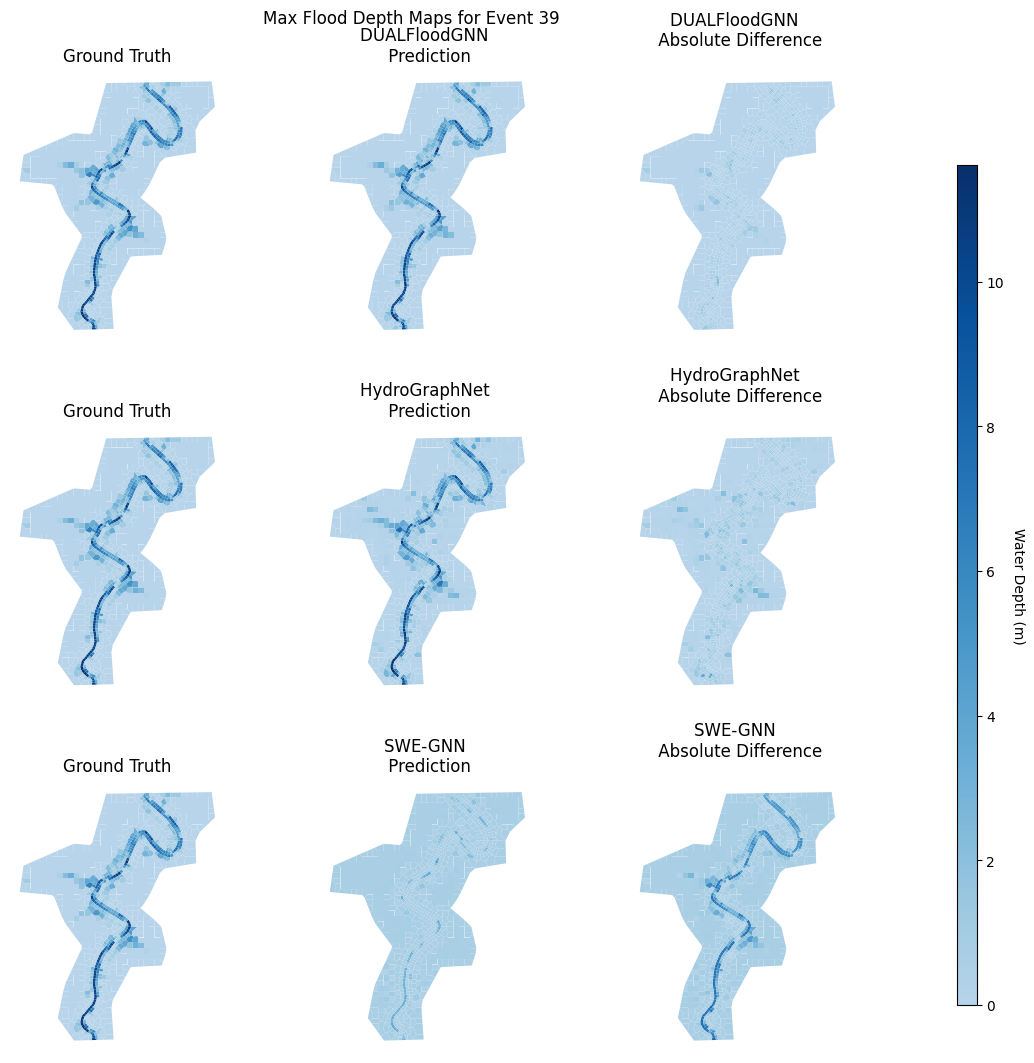

In [34]:
def get_max_depth_map_from_pred(metric_path: str, pred_key: str) -> np.ndarray:
    path_idx = wd_paths.index(metric_path)
    wd_pred = wd_predictions[path_idx]
    max_depth_map = wd_pred.max(axis=0)
    return max_depth_map

max_depth_map_gt = wd_ground_truth.max(axis=0)
plot_max_map_difference(
    metric_paths=wd_paths,
    gpdf=node_df,
    ground_truth=max_depth_map_gt,
    max_map_func=get_max_depth_map_from_pred,
    pred_key='',
    colorbar_label='Water Depth (m)',
    map_type='Depth',
    labels=wd_labels,
)

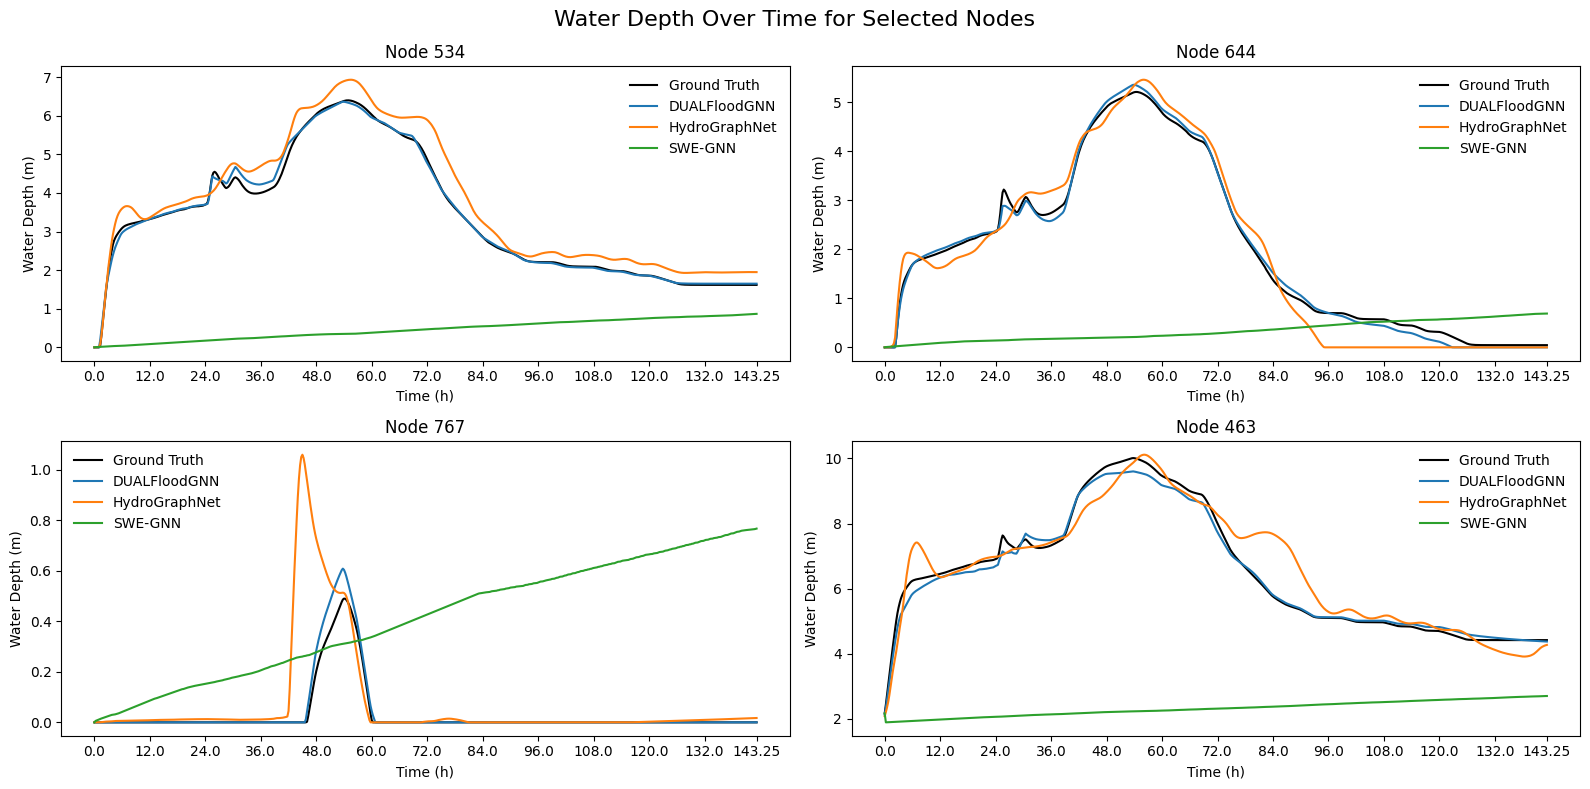

In [35]:
def plot_cell_wd_as_single_plot(pred_list: list[str],
                                node_idxs: list[int],
                                wd_ground_truth: np.ndarray = None,
                                labels: list[str] = None):
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in metric_paths]

    # Create subplots for multiple nodes
    num_nodes = len(node_idxs)
    ncols = min(2, num_nodes)  # Max 2 columns
    nrows = (num_nodes + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows))
    if num_nodes == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes if ncols > 1 else [axes]
    else:
        axes = axes.flatten()

    for node_idx_pos, node_idx in enumerate(node_idxs):
        ax = axes[node_idx_pos] if num_nodes > 1 else axes[0]
        handles = []

        ax.set_ylabel('Water Depth (m)')
        ax.set_xlabel(xlabel)
        ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)

        if wd_ground_truth is not None:
           gt_line, = ax.plot(wd_ground_truth[:, node_idx], label='Ground Truth', color='black')
           handles.append(gt_line)

        data_shape = None
        for i, pred in enumerate(pred_list):
            if data_shape is None:
                data_shape = pred.shape
            assert pred.shape == data_shape, f"Data shape mismatch for path {i}: {pred.shape} vs {data_shape}"

            line, = ax.plot(pred[:, node_idx], label=labels[i])
            handles.append(line)

        ax.set_title(f'Node {node_idx}')
        ax.legend(handles=handles, labels=['Ground Truth', *labels] if wd_ground_truth is not None else labels, framealpha=0)

    # Hide unused subplots
    for i in range(num_nodes, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Water Depth Over Time for Selected Nodes', fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.tight_layout()

plot_cell_wd_as_single_plot(wd_predictions, node_idxs, wd_ground_truth=wd_ground_truth, labels=wd_labels)